## Building a Simple Image Classifier

In [ ]:
# %pip install fastai
import os
import fastai

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "Picasso art"
1. Use DuckDuckGo to search for images of "Monet art"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a painting and see how accurate it is

## Step 1: Download images of Picasso and Monet Art

In [4]:
# %pip install duckduckgo_search
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords,max_results=max_images)).itemgot('image')

Let's start by searching for a Picasso photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [50]:
urls = search_images('Picasso art', max_images=1)
urls[0]

'https://cdn11.bigcommerce.com/s-5qm28d53av/images/stencil/2560w/products/330/9318/Woman-s-head-and-self-portrait-1929-Picasso__04078.1586802926.jpg?c=1'

...and then download a URL and take a look at it:

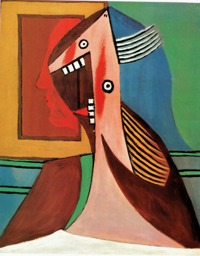

In [51]:
from fastdownload import download_url
from fastai.vision.all import *
from PIL import Image
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

dest = 'Picasso.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)


Now let's do the same with "Monet art":

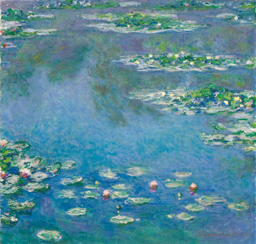

In [7]:
download_url(search_images('Monet art', max_images=1)[0], 'Monet.jpg', show_progress=False)
Image.open('Monet.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "Picasso" and "Monet" paintings, and save each group of photos to a different folder:

In [8]:
searches = 'Picasso','Monet'
path = Path('picasso_or_monet')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} art'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

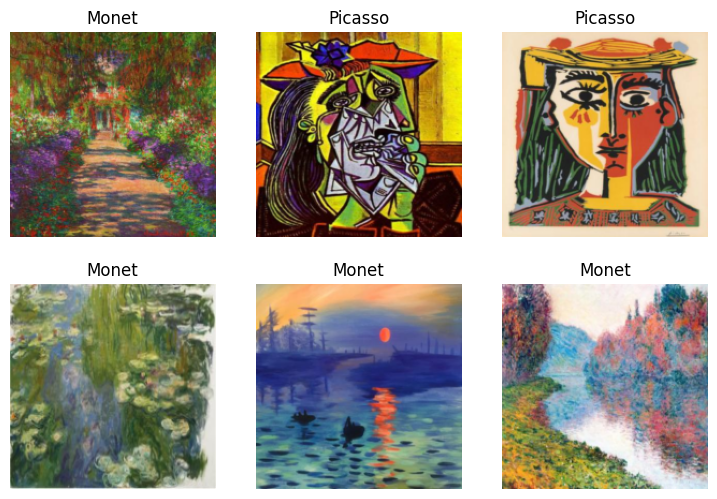

In [42]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "Picasso" or "Monet").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *Picasso* or *Monet*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model using `resnet18`. 

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [45]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.913820,0.169386,0.047244,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.033498,0.023020,0.007874,00:02
1,0.019543,0.000174,0.000000,00:02
2,0.013730,0.000077,0.000000,00:02
3,0.009648,0.000107,0.000000,00:02


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

## Step 3: Using our model

Let's see what our model thinks about that Monet & Picasso photos we downloaded at the start:

This is a: Monet painting
Probability it's a Monet painting: 1.0000


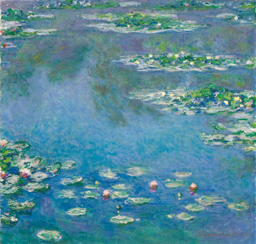

In [47]:
is_monet,_,probs = learn.predict(PILImage.create('Monet.jpg'))
print(f"This is a: {is_monet} painting")
print(f"Probability it's a Monet painting: {probs[0]:.4f}")
Image.open('Monet.jpg').to_thumb(256,256)

This is a: Picasso painting
Probability it's a Monet painting: 0.0000


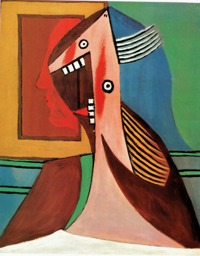

In [52]:
is_monet,_,probs = learn.predict(PILImage.create('Picasso.jpg'))
print(f"This is a: {is_monet} painting")
print(f"Probability it's a Monet painting: {probs[0]:.4f}")
Image.open('Picasso.jpg').to_thumb(256,256)